# REAL1-CG.3135: Real Estate Data Analytics

## Class 13

### Advanced Topics: Introductions to Deep Learning and Bayesian Inference

In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt  
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from tabulate import tabulate
import theano
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)
from pylab import get_cmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.datasets import mnist

from PIL import Image
import urllib.request as url
import io
from IPython.display import Image

Using TensorFlow backend.


## Classification Review: Machine Learning and Test/Train Splits

* Very frequently, we have **categorical labels** in our data, together with features.  



* We will build up the concept of a two-class categorical label based on material we have already discussed.  
    * We will motivate the idea through the use of a **latent** label (or variable).
    * Like time series, we do not observe the underlying DGP.
    * Rather we observe whether or not something **occurred** based on the **realization of a latent index**.  
    * The observation is $\{0, 1\}$ or $\{$not observed, observed$\}$.



* This area of statistical learning is called **classification**.
    * We seek to train a predictor function, $pred$, for a label using $K$ features, $x$.
    * $y_i = pred(x_{i1}, ..., x_{iK})$.



* The **realization** of this predictor, given a feature set, is sometimes called **"yhat"** or $\hat{y}$.



* It is easy to visualize conceptually the nature of this class of questions with scatterplots. 

In [2]:
# Generate some data for scatterplots.

random.seed(12345)
red = np.random.multivariate_normal([-1, 1], [[1,0],[0,1]], 1000)
blue = np.random.multivariate_normal([1, -1], [[1,0],[0,1]], 1000)
arr = np.concatenate((red, blue), axis=0)

Text(0.5, 1.0, 'A Scatterplot')

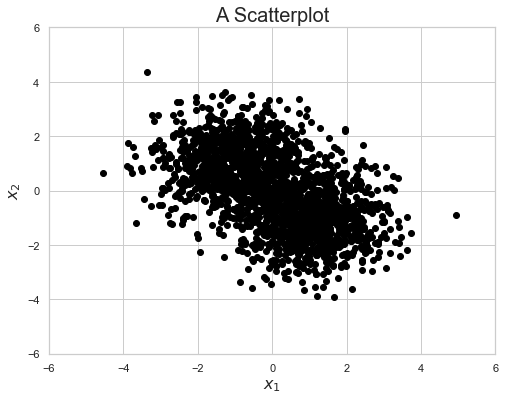

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(arr[0:999, 1], arr[0:999, 0], c="black")
plt.scatter(arr[1000:1999, 1],arr[1000:1999, 0], c="black")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot', fontsize = 20)

#### Notes
1. This scatterplot should be quite familiar by now.  
2. We have two features, $(x_1, x_2)$, and some label, which could be **anything**.
    * A row in our dataframe (or Excel spreadsheet) could be [house price, age, size].
3. Now imagine that the dots are **two flavors**, {red, blue}.
    * That is, a row in the dataframe contains three columns, a label and two features.
    * [flavor, $x_1$, $x_2$].  
    * For example, [red, -2, 2].

Text(0.5, 1.0, 'A Scatterplot with Red-Blue Labels')

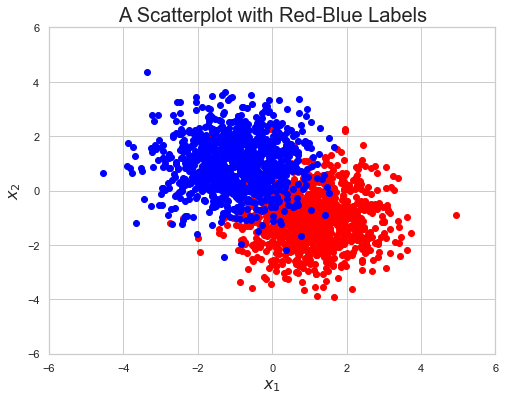

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(arr[0:999, 1], arr[0:999, 0], c="red")
plt.scatter(arr[1000:1999, 1],arr[1000:1999, 0], c="blue")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$', fontsize = 16)
plt.ylabel(r'$x_2$', fontsize = 16)
plt.title(r'A Scatterplot with Red-Blue Labels', fontsize = 20)

#### How We Will Proceed
1. Start with an algorithm we have been using for the entire semester.
2. Turn to a very popular algorithm used for classification of labels with two classes.
    * 1 and 2 combined constitute a very large share of the algorithms used in applied data science.
3. Examine algorithms to predict multi-class labels. 

## Classification: The Linear Probability Model and The Logistic Classifier (or "Logit")

* The use case in multiple regression was to examine how house prices in Staten Island varied with characteristics (or features) of the houses themselves.  
    * This use case involved a continuous label, house prices.  
    * That is, $y$ was quantitative: the sales prices of single-family houses in Staten Island.  
    * Frequently, in data science, we face categorical labels, as above.  
* In economics, we call this the analysis of "limited dependent variables." 
* In computer science, it is classification.  
    * This different terminology refers to the **same thing**.  
* Because this classifier is the ground upon which data scientists of all stripes converge, it is an important methodological technique that I want you to understand **thoroughly**.

### Latent Labels (or Variables)

* One can think of categorical variable as being driven by an underlying DGP.
    * As with time series, we do not observe the continuous process.
    * We observe realizations.
* Consider the now familiar DGP: $y_i^*=x_i^\prime\beta+\epsilon_i$
* $y_i^*$ is a latent value for person *i* that is **unobserved by us**.  
    * For example, you do not observe the value I place on this canister of water.  
    * You simply observe me drinking it.  
    * In other words, you observe the outcome my choice set $\{$drink, not drink$\}$.  
    * Another example would be observing someone taking a taxi.  
    * You do not observe the value that someone places on the taxi ride.  You know that she has many alternative methods of transportation, all with varying values to her, but you observe the outcome of her choice.
* $x_i$ are a vector of features (or attributes or predictors or independent variables).  We observe these.
* $\beta$ is a vector that measures how features affect the latent index, which we will estimate statistically. 
* $\epsilon_i$ retains its status as our ignorance.  

**What do we observe?**

${\displaystyle d_i = }$
$\left\{ \begin{array}{l l} 
{1} & \quad \text{if person i takes a cab, which happens when } y_i^*\ge0\\ 
{0} & \quad \text{if person i does not take a cab, which happens when } y_i^*\lt0 \\
\end{array} \right.$  

## The Logistic Classifier

Again, we start with a sample of size, $N$.  We are going to change the linear model to the following:

$Pr(d_i=1)=x_i^\prime\beta+\epsilon_i$

We will then impose a distributional assumption on $\epsilon_i$, namely that it is logistically distributed.

${\displaystyle Pr(d_i=1) = \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}}$ 

We see immediately that this is NOT **a linear model** (that is, a model that is linear in $\beta$).

${\displaystyle Pr(d_i=0) = 1 - Pr(d_i=1) = 1 - \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)} = \frac{1}{1+\exp(x_i^\prime\beta)}}$

An **odds ratio**:

${\displaystyle \frac{Pr(d_i=1)}{Pr(d_i=0)} = \frac{Pr(d_i=1)}{1 - Pr(d_i=1)} = \exp(x_i^\prime\beta)}$

This implies that the log-odds ratio (or "logit") is:

${\displaystyle \log\big(\frac{Pr(d_i=1)}{1 - Pr(d_i=1)}\big) = x_i^\prime\beta}$, which is linear in $\beta$.

To address the estimation of the parameters of interest, we need to construct a likelihood function that we will tell the computer to optimize.  Start by constructing the likelihood for observation $i$:

${\displaystyle l_i = Pr(d_i=1)^{d_i}\cdot Pr(d_i=0)^{(1-d_i)}=\frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

If we make some assumptions we can write:

${\displaystyle L = \prod_{i=1}^N l_i = \prod_{i=1}^N \frac{\exp(x_i^\prime\beta)}{1+\exp(x_i^\prime\beta)}^{d_1}\frac{1}{1+\exp(x_i^\prime\beta)}^{(1-d_i)}}$

Goal is to tell the machine to maximize $L$ with respect to $\beta$ given the data we have. 

Once we have done that, we can make probabilistic predictions (or classifications).

### Recall the Confusion Matrix

In [5]:
print("What is a confusion matrix, and what might we do with its elements?")
print("")
print()
table = [[" ","0", "1"],["0", "TN", "FP"],["1", "FN", "TP"]]
print(tabulate(table, tablefmt="fancy_grid", numalign = "center"))
print()

print("Zeros are negatives, and ones are positives")
print("Correctly predicting a 0 is a True Negative")
print("Correctly predicting a 1 is a True Positive")
print("Incorrectly predicting a 0 is a False Negative")
print("Incorrectly predicting a 1 is a Fale Positive")
print("")
print("The True Positive Rate is TP / (TP + FN)") 
print("The False Positive Rate is FP / (TN + FP)")
print("The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)")
print("The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction")

What is a confusion matrix, and what might we do with its elements?


╒═══╤════╤════╕
│   │ 0  │ 1  │
├───┼────┼────┤
│ 0 │ TN │ FP │
├───┼────┼────┤
│ 1 │ FN │ TP │
╘═══╧════╧════╛

Zeros are negatives, and ones are positives
Correctly predicting a 0 is a True Negative
Correctly predicting a 1 is a True Positive
Incorrectly predicting a 0 is a False Negative
Incorrectly predicting a 1 is a Fale Positive

The True Positive Rate is TP / (TP + FN)
The False Positive Rate is FP / (TN + FP)
The Accuary Rate is (TN + TP) / (TN + FP + FN + TP)
The Mean Squared Error is the Average Squared Deviation Between the Truth and Our Prediction


### Digression: The Mean Squared Error and Bias/Variance Decomposition
* For any predictor, $\hat{y}$, of label, $y$, with a dataframe of size $N$, the MSE is ${\displaystyle =\frac{1}{N}\sum_{i=1}^N(y_i - \hat{y_i})^2}$.
    * In words, the MSE is the average of the **squared deviations** between our prediction and the truth.  
    * We have already seen this measure.  Without the $\frac{1}{N}$, it is the Sum of Squared Residuals function, $SSR(\beta)$, that we minimized with the linear regression model.  
    * We simply normalize it by the dataframe size (which does not alter the optimal values of $\beta$).  



* In practice, we do not much care about the overall MSE, but the MSE associated with the test set, in which case we simply limit the calculation to the test set.  



* It can be shown with some basic algebra that the MSE can be **decomposed**.  
    * $MSE \propto Var(\hat y) + Bias(\hat y)$
    * What do the *variance* and *bias* of a learning algorithm capture? 



* *Variance* refers to the amount by which $\hat y$ would change if we train the algorithm using a different training set.  
    * Since the training data are used to train the algorithm, a different training set would result in a different $\hat y$.  
    * Ideally $\hat y$ should not considerably vary between training sets because an algorithm that has high variance implies that small changes in training sets can result in large changes in $\hat{y}$.  
    * **Generally, more flexible statistical methods have higher variance.**  That is, they are sensitive to their training sets.
    
    

* *Bias* refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a simple representation.  
    * For example, linear regression assumes that there is a linear relationship between between the label and the features, $\hat y = x'\hat \beta$.  
    * It is unlikely that any real-life use case truly has such a simple linear relationship, and so performing linear regression will undoubtedly result in some bias in the estimate of $\hat{y}$.  
    * **Generally, more flexible statistical methods result in less bias.**  That is, including higher order terms (squares, cubics, or interactions) increases the predictive power ( which lowers bias), but decreases our ability easily to interpret the results.



* This is called the **bias-variance tradeoff**.


* **It is inherent in any machine learning algorithm**.  

### An Introduction to Neural Networks and Deep Learning
#### The Logit as the Precusor to Deep Learning

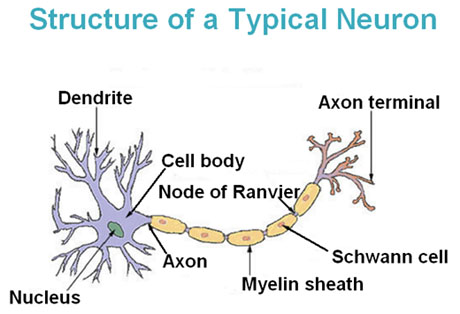

In [6]:
from IPython.display import Image
url = "https://upload.wikimedia.org/wikipedia/commons/b/bd/Neuron.jpg"
Image(url, width=400, height=400)

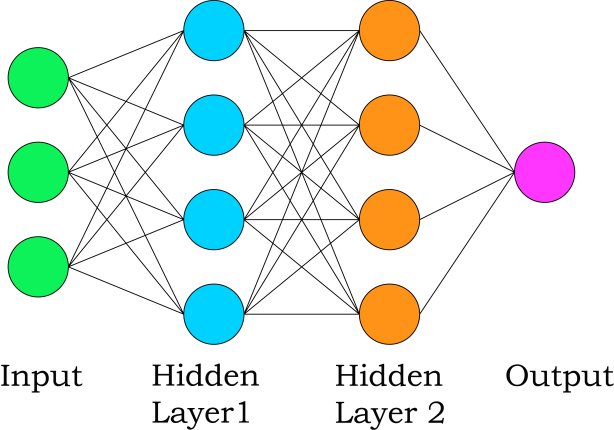

In [7]:
#from IPython.display import Image
url = 'https://en.mlab.ai/sites/default/files/inline-images/neural1_1.jpg'
Image(url, width=400, height=400)

### Overview
* Because of their remarkable success in digital image processing, among other areas of data science, the origin of neural networks, the precusor to deep learning, is claimed by many disciplines and by many people.



* The "electronic brain" and the neuroscience of the 1950's.
    * Computer science: Character recongition and the U.S. Postal Service.
    * Economics and finance: Let's make a million dollars!
    * Like many approaches in data science, the technique has waxed and waned through the ages, seemingly rediscovered each time.



* Let's not focus on the past (despite my personal interest on the origin of algorithms). Let's focus on the present. Fortunately, we've already seen a simple example of a neural network: the logit classifier (reviewed above).



* The logit classifier is a simple neural network: feed-forward MLP with one hidden layer.
    * A neural network builds on this simple concept by introducing many "logits" and tying them together with weights.
    * We estimated the $\beta$'s of the logits via maximum likelihood.
    * We tie them with weights that we also esimate via maximum likelihood.

### Computer science

Character recongition, the U.S. Postal Service, and Yann LeCun's famous MNIST data.
A Cambrian-like explosion since 2008.

### Economics and finance
See, among others, papers by Ron Gallant (UNC Chapel Hill), Timothy Savage (NYU), George Tauchen (Duke), and Hal White (UCSD).

## A Motivating Example: The Logic Gate

In [8]:
np.random.seed(1907)
f1 = np.random.randint(0, 2, 10000)
f2 = np.random.randint(0, 2, 10000)
label = np.logical_xor(f1, f2) * 1
data = pd.DataFrame({'label':label, 'f1':f1, 'f2':f2})
data.head(10)

,label,f1,f2
0,0,1,1
1,1,1,0
2,0,1,1
3,0,0,0
4,0,1,1
5,1,1,0
6,0,1,1
7,0,0,0
8,0,0,0
9,1,1,0


### Notes
* A simple data structure that is difficult to analyze using our algorithms to date.
* The train/test split is a different method to evaluate the performance of an algorithm.
    * Randomly split the whole dataset into two parts.
    * Fit the algorithm on the training dataset.
    * Evaluate the performance of the algorithm on the test dataset using the MSE criterion.

In [9]:
datatrain, datatest = train_test_split(data, test_size = 0.2, random_state = 6281993)

In [10]:
# The linear probability model.
# Generate predictions for the test data based on the results of the algorithm fit on the training data.

mod = smf.ols(formula='label ~ f1 + f2', data = datatrain).fit()
print(mod.summary())
datatest['lm_hat'] = mod.predict(exog = datatest)

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9553
Date:                Sun, 27 Dec 2020   Prob (F-statistic):              0.385
Time:                        18:48:05   Log-Likelihood:                -5804.6
No. Observations:                8000   AIC:                         1.162e+04
Df Residuals:                    7997   BIC:                         1.164e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5084      0.010     52.211      0.0

In [11]:
print(datatest['label'].describe())
print("")
print(datatest['lm_hat'].describe())

count    2000.000000
mean        0.499500
std         0.500125
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: label, dtype: float64

count    2000.000000
mean        0.506672
std         0.007677
min         0.495926
25%         0.504838
50%         0.508433
75%         0.517345
max         0.517345
Name: lm_hat, dtype: float64


In [12]:
print((1 - 0.5)**2)
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['lm_hat']))

0.25
The MSE is 0.250072


### Notes
* Using classical hypothesis testing, we would fail to reject the null that the impact of f1 and f2 is zero.
* In the test data, the labels are 0 or 1, with an average value of 0.5.
* For the predicted labels, the average value is about 0.5 with no variability.
* The MSE is $(1 - 0.5)^2$

In [13]:
# The logit algorithm.
# Generate predictions for the test data based on the results of the algorithm fit on the training data.

mod = smf.logit(formula='label ~ f1 + f2', data = datatrain).fit()
print(mod.summary())
datatest['logit_hat'] = mod.predict(exog = datatest)

Optimization terminated successfully.
         Current function value: 0.692937
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7997
Method:                           MLE   Df Model:                            2
Date:                Sun, 27 Dec 2020   Pseudo R-squ.:               0.0001723
Time:                        18:48:05   Log-Likelihood:                -5543.5
converged:                       True   LL-Null:                       -5544.4
Covariance Type:            nonrobust   LLR p-value:                    0.3846
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0337      0.039      0.866      0.386      -0.043       0.110
f1            -0.0500      0.

In [14]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['logit_hat']))

The MSE is 0.250073


In [15]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat
2803      1   0   1  0.517345   0.517343
5397      1   0   1  0.517345   0.517343
1739      0   1   1  0.504838   0.504839
5103      1   0   1  0.517345   0.517343
3750      0   0   0  0.508433   0.508434
1654      1   1   0  0.495926   0.495924
3057      1   1   0  0.495926   0.495924
8124      0   0   0  0.508433   0.508434
6477      0   0   0  0.508433   0.508434
6597      1   1   0  0.495926   0.495924
8399      1   1   0  0.495926   0.495924
494       0   1   1  0.504838   0.504839
4775      1   1   0  0.495926   0.495924
3787      0   0   0  0.508433   0.508434
7204      0   0   0  0.508433   0.508434
1951      1   0   1  0.517345   0.517343
2198      1   1   0  0.495926   0.495924
4699      0   0   0  0.508433   0.508434
2602      1   0   1  0.517345   0.517343
6044      1   1   0  0.495926   0.495924


### Notes 
* Note that both algortithms perform poorly.
* Easy to impliment, but they cannot "fit" the logit gate.
* Hence, the development of neural networks, the precusor to deep learning.

In [16]:
X_train = datatrain[['f1', 'f2']].values
y_train = datatrain['label'].values
X_test = datatest[['f1', 'f2']].values
y_test = datatest['label'].values
dim = X_train.shape[1]

In [17]:
# This the simplest neural network, the multilayer perceptron with one hidden layer.

np.random.seed(1066)

model = keras.Sequential([
    keras.layers.Dense(1, activation='relu', input_dim=dim),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 - 2s - loss: 0.6926 - accuracy: 0.5571 - val_loss: 0.6910 - val_accuracy: 0.7500
Epoch 2/10
8000/8000 - 0s - loss: 0.6897 - accuracy: 0.7542 - val_loss: 0.6884 - val_accuracy: 0.7500
Epoch 3/10
8000/8000 - 0s - loss: 0.6869 - accuracy: 0.7542 - val_loss: 0.6854 - val_accuracy: 0.7500
Epoch 4/10
8000/8000 - 0s - loss: 0.6838 - accuracy: 0.7542 - val_loss: 0.6822 - val_accuracy: 0.7500
Epoch 5/10
8000/8000 - 0s - loss: 0.6803 - accuracy: 0.7542 - val_loss: 0.6785 - val_accuracy: 0.7500
Epoch 6/10
8000/8000 - 0s - loss: 0.6765 - accuracy: 0.7542 - val_loss: 0.6745 - val_accuracy: 0.7500
Epoch 7/10
8000/8000 - 0s - loss: 0.6724 - accuracy: 0.7542 - val_loss: 0.6703 - val_accuracy: 0.7500
Epoch 8/10
8000/8000 - 0s - loss: 0.6681 - accuracy: 0.7542 - val_loss: 0.6657 - val_accuracy: 0.7500
Epoch 9/10
8000/8000 - 0s - loss: 0.6634 - accuracy: 0.7542 - val_loss: 0.6610 - val_accuracy: 0.7500
Epoch 10/10
8000/8000 - 0s - loss:

In [18]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.231505


In [19]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat    dl_hat
2803      1   0   1  0.517345   0.517343  0.517667
5397      1   0   1  0.517345   0.517343  0.517667
1739      0   1   1  0.504838   0.504839  0.439120
5103      1   0   1  0.517345   0.517343  0.517667
3750      0   0   0  0.508433   0.508434  0.517732
1654      1   1   0  0.495926   0.495924  0.517732
3057      1   1   0  0.495926   0.495924  0.517732
8124      0   0   0  0.508433   0.508434  0.517732
6477      0   0   0  0.508433   0.508434  0.517732
6597      1   1   0  0.495926   0.495924  0.517732
8399      1   1   0  0.495926   0.495924  0.517732
494       0   1   1  0.504838   0.504839  0.439120
4775      1   1   0  0.495926   0.495924  0.517732
3787      0   0   0  0.508433   0.508434  0.517732
7204      0   0   0  0.508433   0.508434  0.517732
1951      1   0   1  0.517345   0.517343  0.517667
2198      1   1   0  0.495926   0.495924  0.517732
4699      0   0   0  0.508433   0.508434  0.517732
2602      1   0   1  0.517345  

### Notes
* The hidden layer improves the performance of the model only modestly.
* Let's continue to add hidden perceptrons, as well as additional layers.

In [20]:
np.random.seed(1066)

model = keras.Sequential([
    keras.layers.Dense(5, activation='relu', input_dim=dim),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 - 1s - loss: 0.6938 - accuracy: 0.4011 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 2/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 3/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 4/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 6/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 7/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 8/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 9/10
8000/8000 - 0s - loss: 0.6931 - accuracy: 0.5067 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 10/10
8000/8000 - 0s - loss:

In [21]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.250044


In [22]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat    dl_hat
2803      1   0   1  0.517345   0.517343  0.506174
5397      1   0   1  0.517345   0.517343  0.506174
1739      0   1   1  0.504838   0.504839  0.506174
5103      1   0   1  0.517345   0.517343  0.506174
3750      0   0   0  0.508433   0.508434  0.506174
1654      1   1   0  0.495926   0.495924  0.506174
3057      1   1   0  0.495926   0.495924  0.506174
8124      0   0   0  0.508433   0.508434  0.506174
6477      0   0   0  0.508433   0.508434  0.506174
6597      1   1   0  0.495926   0.495924  0.506174
8399      1   1   0  0.495926   0.495924  0.506174
494       0   1   1  0.504838   0.504839  0.506174
4775      1   1   0  0.495926   0.495924  0.506174
3787      0   0   0  0.508433   0.508434  0.506174
7204      0   0   0  0.508433   0.508434  0.506174
1951      1   0   1  0.517345   0.517343  0.506174
2198      1   1   0  0.495926   0.495924  0.506174
4699      0   0   0  0.508433   0.508434  0.506174
2602      1   0   1  0.517345  

In [23]:
np.random.seed(1066)

model = keras.Sequential([
    keras.layers.Dense(5, activation='relu', input_dim=dim),
    keras.layers.Dense(25, activation='relu', input_dim=dim),
    keras.layers.Dense(25, activation='relu', input_dim=dim),
    keras.layers.Dense(25, activation='relu', input_dim=dim),    
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
datatest['dl_hat'] = model.predict(X_test)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 - 2s - loss: 0.6535 - accuracy: 0.8919 - val_loss: 0.6004 - val_accuracy: 1.0000
Epoch 2/10
8000/8000 - 0s - loss: 0.5011 - accuracy: 1.0000 - val_loss: 0.3648 - val_accuracy: 1.0000
Epoch 3/10
8000/8000 - 0s - loss: 0.2186 - accuracy: 1.0000 - val_loss: 0.0941 - val_accuracy: 1.0000
Epoch 4/10
8000/8000 - 0s - loss: 0.0474 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 5/10
8000/8000 - 0s - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 6/10
8000/8000 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/10
8000/8000 - 0s - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 8/10
8000/8000 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 9/10
8000/8000 - 0s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 10/10
8000/8000 - 0s - loss:

In [24]:
print("The MSE is %f" % mean_squared_error(datatest['label'], datatest['dl_hat']))

The MSE is 0.000002


In [25]:
print(datatest.head(20))

      label  f1  f2    lm_hat  logit_hat    dl_hat
2803      1   0   1  0.517345   0.517343  0.998544
5397      1   0   1  0.517345   0.517343  0.998544
1739      0   1   1  0.504838   0.504839  0.000406
5103      1   0   1  0.517345   0.517343  0.998544
3750      0   0   0  0.508433   0.508434  0.002526
1654      1   1   0  0.495926   0.495924  0.999696
3057      1   1   0  0.495926   0.495924  0.999696
8124      0   0   0  0.508433   0.508434  0.002526
6477      0   0   0  0.508433   0.508434  0.002526
6597      1   1   0  0.495926   0.495924  0.999696
8399      1   1   0  0.495926   0.495924  0.999696
494       0   1   1  0.504838   0.504839  0.000406
4775      1   1   0  0.495926   0.495924  0.999696
3787      0   0   0  0.508433   0.508434  0.002526
7204      0   0   0  0.508433   0.508434  0.002526
1951      1   0   1  0.517345   0.517343  0.998544
2198      1   1   0  0.495926   0.495924  0.999696
4699      0   0   0  0.508433   0.508434  0.002526
2602      1   0   1  0.517345  

### Notes
* The MLP improves the performance of the algorithm considerably.
* Can be implemented with little computational burden.

## Images as Data
* Images can be digitized and therefore analyzed.
* Deep learning algorithms were developed for this purpose.
* Let's use an example with clothing.

In [26]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

A shoe


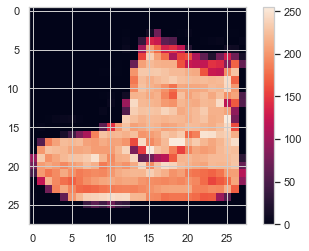

In [27]:
print('A shoe')

plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(True)
plt.show()

In [28]:
# Think of this as a spreadsheet.

train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

In [29]:
# Normalize data.

train_images = train_images / 255.0
test_images = test_images / 255.0

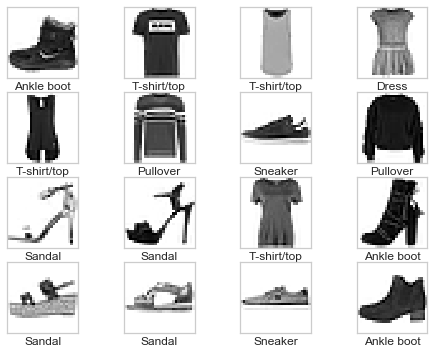

In [30]:
plt.figure(figsize=(8, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [31]:
# 6000 of each type of clothing

print(np.unique(class_names, return_counts=True))
print(np.unique(train_labels, return_counts=True))

(array(['Ankle boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal',
       'Shirt', 'Sneaker', 'T-shirt/top', 'Trouser'], dtype='<U11'), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


In [32]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], verbose=2)
model.fit(train_images, train_labels, epochs=10)
predictions = model.predict(test_images)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 235us/sample - loss: 0.4866 - accuracy: 0.8266
Epoch 2/10
60000/60000 [==============================] - 15s 251us/sample - loss: 0.3635 - accuracy: 0.8660
Epoch 3/10
60000/60000 [==============================] - 15s 245us/sample - loss: 0.3281 - accuracy: 0.8790
Epoch 4/10
60000/60000 [==============================] - 14s 238us/sample - loss: 0.3029 - accuracy: 0.8874
Epoch 5/10
60000/60000 [==============================] - 14s 229us/sample - loss: 0.2874 - accuracy: 0.8926
Epoch 6/10
60000/60000 [==============================] - 19s 312us/sample - loss: 0.2700 - accuracy: 0.8978
Epoch 7/10
60000/60000 [==============================] - 14s 239us/sample - loss: 0.2597 - accuracy: 0.9012
Epoch 8/10
60000/60000 [==============================] - 18s 292us/sample - loss: 0.2482 - accuracy: 0.9059
Epoch 9/10
60000/60000 [==============================] - 15s 257us/sample - loss: 0.2400 - accuracy: 0.9

In [33]:
predictions.argmax(axis=1)
test_labels

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

In [34]:
# Standard measures of performance.
# First, the accuracy rate on the test or validation set.
# Second, the multiclass confusion matrix.
# Third, precision by class.

from sklearn.metrics import accuracy_score
print('Accuracy Rate: %f' % accuracy_score(test_labels, predictions.argmax(axis=1)))

Accuracy Rate: 0.878700


In [35]:
from sklearn.metrics import confusion_matrix
print('Confusion matrix:\n%s' % confusion_matrix(test_labels, predictions.argmax(axis=1)))

Confusion matrix:
[[848   3  22  10   4   1 108   0   4   0]
 [  2 972   2  13   8   1   1   0   1   0]
 [ 15   1 805   4 140   0  35   0   0   0]
 [ 50   4  32 800  86   0  26   0   2   0]
 [  0   0 100   9 863   0  28   0   0   0]
 [  0   0   0   0   0 964   0  19   1  16]
 [117   0 127  16  86   0 649   0   5   0]
 [  0   0   0   0   0   8   0 970   0  22]
 [  5   0   8   2  12   1   6   4 962   0]
 [  0   0   0   0   0   4   1  41   0 954]]


In [36]:
from sklearn.metrics import classification_report
print('Classification Report:')
print(classification_report(test_labels, predictions.argmax(axis=1)))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.73      0.81      0.77      1000
           3       0.94      0.80      0.86      1000
           4       0.72      0.86      0.78      1000
           5       0.98      0.96      0.97      1000
           6       0.76      0.65      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.99      0.96      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [37]:
# Identify errors.

(test_labels - predictions.argmax(axis = 1) > 0).nonzero()

(array([  12,   17,   23,   25,   40,   51,   68,   89,   98,  107,  135,
         147,  150,  192,  239,  241,  244,  252,  282,  316,  325,  378,
         382,  406,  441,  444,  460,  474,  526,  529,  536,  548,  562,
         563,  565,  572,  584,  586,  595,  634,  635,  639,  664,  669,
         688,  689,  697,  699,  711,  716,  725,  732,  753,  761,  805,
         823,  860,  875,  905,  909,  920,  921,  956,  960,  963,  977,
         979,  994,  996, 1004, 1025, 1029, 1055, 1056, 1107, 1121, 1129,
        1131, 1152, 1160, 1162, 1165, 1174, 1197, 1210, 1223, 1235, 1294,
        1300, 1329, 1336, 1455, 1458, 1469, 1471, 1487, 1496, 1502, 1509,
        1515, 1522, 1620, 1632, 1643, 1650, 1662, 1701, 1706, 1744, 1771,
        1792, 1846, 1855, 1895, 1917, 1922, 1939, 1943, 1954, 1968, 1975,
        1980, 2003, 2006, 2016, 2021, 2042, 2057, 2069, 2110, 2136, 2138,
        2144, 2162, 2181, 2191, 2195, 2202, 2290, 2297, 2311, 2318, 2320,
        2351, 2373, 2397, 2417, 2421, 

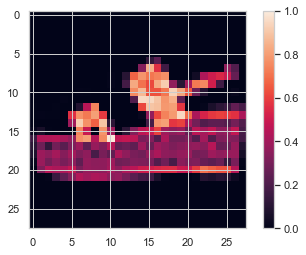

True label is 7
The algorithm classifies it as a 5 with probability 0.977942


In [38]:
img = 12
plt.figure()
plt.imshow(train_images[img])
plt.colorbar()
plt.grid(True)
plt.show()
print('True label is %d' % test_labels[img])
print('The algorithm classifies it as a %d with probability %f' % (predictions[img].argmax(), max(predictions[img])))

### Notes
* Deep learning consists of many different type of algorithms.
* As one can see from the above, the algorithm can make poor predictions with high probability. 

In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label: 
        color = 'blue'
    else: 
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(predictions_array), 
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

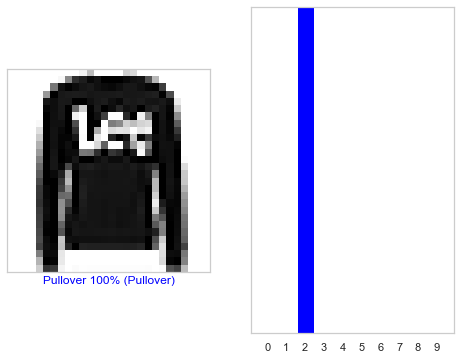

In [40]:
i = 1
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

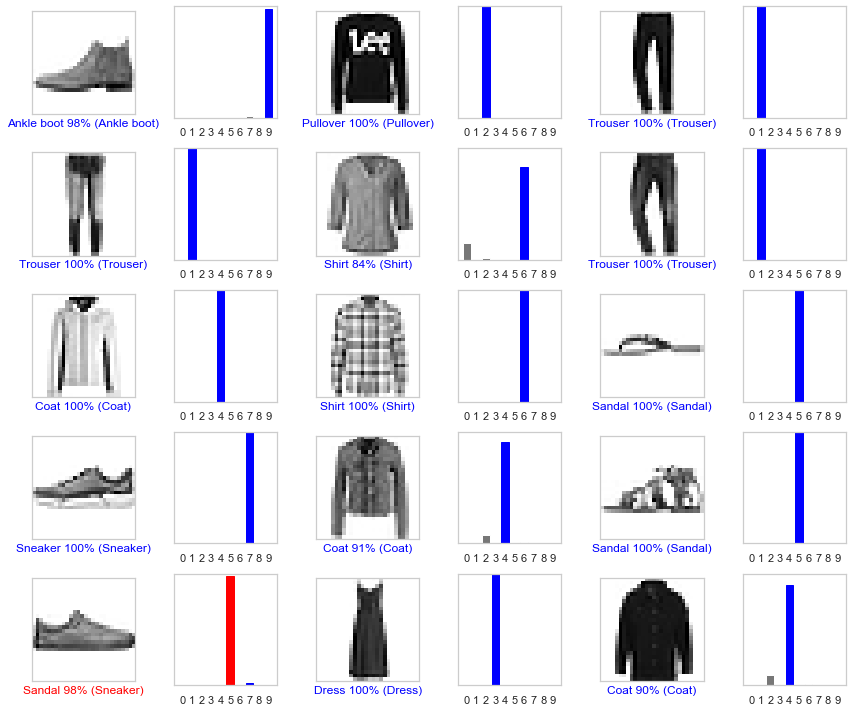

In [41]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

### Deep Learning and Finance

* [Savage and Vo](https://github.com/thsavage/Deep-Learning-and-Finance/blob/master/Deep%20Learning%20and%20Finance%20Poster.pdf) 

## Introduction to Bayesian Inference

>"I can live with doubt and uncertainty... I have approximate answers and possible beliefs and different degrees of certainty about different things, and I'm not absolutely sure of anything..."

>> Richard Feynman

In [42]:
# Load the libraries.

%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt  
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import patsy
from statsmodels.graphics.api import abline_plot
import numpy.linalg as linalg
import pymc3 as pm
import theano
from mpl_toolkits.mplot3d import Axes3D
import fix_yahoo_finance as yf
warnings.simplefilter('ignore')
sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

## Overview
* In this lecture, we will discuss the distinction between the frequentist approach to statistical learning and the Bayesian approach.  You should have already watched the videos on:



1. Conditional Probability
2. An example of Bayes Theorem
3. The "Monte Hall" Problem (which is another example of conditional probability)



* Bayes theorem is typically taught in data analytics courses, such as this one, using the example in the video.  
    * It is presented as a simple exercise at calculating "inverse probability".  
    * The topic of Bayesian analysis is then oddly dropped, and students are asked to refocus on the frequentist approach (using the tools we already discussed).  
    * Having watched the video (and perhaps having solved the problem presented in the video), you have already conducted Bayesian analysis.    



* This purpose of this lecture is to introduce you to the methods by which we can apply Bayes theorem in a meaningful way to real-world data.  To do so, we will address the ingredients of Bayesian inference using a variety of examples.
1. Probabilistically assess whether a coin is balanced (or fair) by combining our prior beliefs with experimental data.  (If you understand this simple example, then you understand the core of the Bayesian approach to inference.)  
2. Use two popular Markov Chain Monte Carlo (MCMC) simulation methods, the Gibbs and the Metropolis-Hastings algorithms.  (The focus here will what they do rather than on how they work.  In particular, you will see that these MCMC algorithms are able to simulate probabilty distributions extraordinarily well.) 
3. Simulate the posterior probabilty distributions of $\alpha$ and $\beta$ from the CAPM.  (Here you will see the strength of the Bayesian approach to inference, in particular the ease of hypothesis testing from a Bayesian perspective.)  



* My goal is for you to:



1. Understand the Bayesian approach to inference.
2. Understand the use of MCMC algorithms as simulation tools of the posterior probability distribution (given data and prior beliefs).
3. To see how simple hypothesis testing really is (and why it is so difficult to explain from a frequentist perspective).

## The Buzz

> "Now Bayesian statistics are rippling through everything from physics to cancer research, ecology to psychology. Enthusiasts say they are allowing scientists to solve problems that would have been considered impossible just 20 years ago. And lately, they have been thrust into an intense debate over the reliability of research results."  

> "The essence of the frequentist technique is to apply probability to data. If you suspect your friend has a weighted [unfair] coin, for example, and you observe that it came up heads nine times out of 10, a frequentist would calculate the probability of getting such a result with an unweighted [fair] coin. The answer (about 1 percent) is not a direct measure of the probability that the coin is weighted [unfair]; it’s a measure of how improbable the nine-in-10 result is — a piece of information that can be useful in investigating your suspicion."

> "By contrast, Bayesian calculations go straight for the probability of the hypothesis, factoring in not just the data from the coin-toss experiment but any other relevant information — including whether you have previously seen your friend use a weighted [unfair] coin."

>> [The New York Times, Sept. 29, 2014](http://www.nytimes.com/2014/09/30/science/the-odds-continually-updated.html)

> "My training as an econometrician, perhaps like many, lay in the canonical texts of Greene (multiple editions), Hamilton (1994), and Campbell et al. (1997)... But these canonical texts have little to no discussion of Bayesian methods of estimation and inference... The treatment does not include the standard MCMC methods used today, Gibbs sampling, or Metropolis-Hastings. Nor is there a discussion of the need for burn-in or the distinction between Bayesian credible intervals and classical confidence intervals."

> "With this backdrop, one might suppose that Bayesian methods have little role to play in the practice of empirical analysis, and particularly not real estate. As Sharon Bertsch McGrayne richly explores in The Theory that Would Not Die, however, the Bayesian approach to estimation and inference has survived every intellectual objection, both
philosophical and utilitarian, for nearly two centuries."

> "The now-familiar Bayes-Price-Laplace formula states that the posterior probability distribution over a parameter of interest is proportional to its prior probability distribution, the researcher’s degree of belief, times the likelihood function describing the data. On paper, this is a logically-consistent approach to learning and hypothesis
testing. But mathematically, closed-form solutions are limited, and only recent advances in computational power have made it tractable for general application."

> "The physicist Richard Feynman once said that, ‘I can live with doubt and uncertainty... I have approximate answers and possible beliefs and different degrees of certainty about different things, and I’m not absolutely sure of anything...’ Arguably, this is not a statement that sees probability as the outcome of history of coin flips. Economics and finance researchers study constrained decision-making under uncertainty. Real estate development and investing, given its vast array of risk, is a case study for living with doubt and uncertainty. For every real estate success, there may be a large corpus of failure, where probability as the outcome of a history provides little guidance. As a result, a Bayesian approach, either philosophical or practical, might be a tonic."

>> Savage (2019), [Review](file:///Users/timothysavage/Downloads/The%20Theory%20That%20Would%20Not%20Die.pdf) of *The Theory that Would Not Die: How Bayes’ Rule Cracked the Enigma Code, Hunted Down Russian Submarines, and Emerged Triumphant from Two Centuries of Controversy*

## Why?

1. General increase in the demand for data analytics generally and real estate specifically.
    * Sparse data that is updated and expanded with time.
2. Clinical trials.
3. Survey research.
4. Data-driven policy evaluation in both the public and private sectors.
5. Computational speed and the advance of open source statistical learning environments, such as R and Python.
6. Limitations of the frequentist approach to inference that are now hindering the advance of data analytics in decision- and policy-making.  In particular, the implicit reliance on **non-existent** repeated samples and fixed parameter values that underlies the frequentist approach to data science.
    > Were this procedure to be *repeated on numerous samples*, the fraction of calculated confidence intervals (which would differ for each sample) that encompass the true population parameter would tend toward 95%.

## A Brief History
* Mathematicians Laplace, Legendre, de Morgan, and Gauss (1700’s through 1850’s) lay the foundations of probability and statistics as a formal branch of mathematics.  
    * An essay by the Rev. Thomas Bayes is published after his death.  
    * Laplace reformulates a mathematically-coherent version, called *law of inverse probability*.  
    * The law of inverse probability is essentially a statement about inductive reasoning that we do all the time.  



* Statisticians Fisher, Neyman, and the Pearsons (father and son) develop the classical interpretation of statistical inference (early 1900’s).  
    * Fisher is personally hostile to Bayesian inference, calling it an “impenetrable jungle”.  In the early 1960's, interest in approach was re-ignited by scholars such Jeffreys, Savage, de Finetti, and Lindley.  
    * This was partially driven by the Markov Chain Monte Carlo (MCMC) simulation approach developed in statistical physics by Metropolis.  (We will implement a version of his method below.)



* With the development of modern computational speed, it is easy to implement MCMC, which has greatly expanded the scope of Bayesian inference.  

## Distinctions
* The frequentist approach to inference treats the unknown parameters of interest, such as the $\beta$’s in the linear model, as constants to be statistically estimated using data.  
    * Using this approach, we evaluate hypotheses using confidence intervals as if we had “repeated samples”.



* For example, for CAPM, we statistically estimated $\alpha$ and $\beta$ using the principle of least squares and obtained point estimates of their values.  
    * Using a 95% confidence interval, we tested the hypothesis that $\beta=$1 by asking whether a 95% confidence interval includes 1.  
    * But the concept of a 95% confidence interval is derived from the idea of so-called "repeated samples".  
    * In repeated samples, a 95% confidence interval will cover the true, fixed parameter value 95% of the time.  
    * In the typical applied setting, however, the idea of repeated samples is meaningless.  
    * **You have one data set.**  
    * There is no reason to believe that the unknown parameters of interest are constant (or fixed in repeated samples even if you had access to them).  
    * It is unclear how to incorporate prior information. 



* The Bayesian approach to inference treats the unknown parameters of interest *probabilistically*.  
    * That is, rather than viewing them as fixed constants, the Bayesian approach views them as probability distribution functions, from which we can calculate certain things, such as a mean and a standard deviation.
    * Hypothesis testing can then address the more meaningful questions such as, in CAPM, what is the probability that $\alpha \ge 0$ or $\beta \le 1$?  Probabilistic answers to these questions could actually drive meaningful decision making.   



* In addition, the Bayesian approach incorporates prior beliefs about the unknown parameters of interest.  
    * Those beliefs can be vague or specific, but they too are expressed in term of probability distribution functions.
    * As such, the Bayesian approach to analysis is consistent with *how humans learn*.

## Three Important Bayesian Terms
1. **Prior probability**: a probabilistic expression of a data scientist's belief regarding the unknown parameters of interest prior to the observation of any data (for example, beliefs about the $\beta$'s from the linear model).

2. **Likelihood**: a probabilistic expression regarding the observed data.

3. **Posterior probability**: a probabilistic expression of a data scientist’s updated beliefs based on observed data.



* It is important for you to understand that all of these are expressed explicitly in terms of **probabilty distribution functions**.



* Conceptually, the approach is straightforward.

1.  Express your **prior beliefs** about the unknown parameters of interest in terms of a probability distribution.

2.  Collect data and express the data in terms of a probability distribution, **called the likelihood**.

3.  Update your beliefs about the unknown parameters of interest by **combining 1 and 2**.



* This process gives rise to the general Bayesian statement: 

* Posterior $\propto$ Likelihood $\times$ Prior

## Digression on Probability Distributions

### Uniform Distribution
* A prior distribution that expresses vague beliefs.

(0, 0.8)

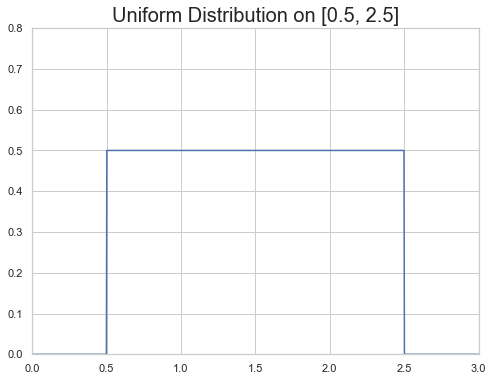

In [43]:
plt.figure(figsize = (8, 6))
x = np.linspace(0, 3, 1000)
a = 0.5
b = 2.5
l = b - a
plt.title('Uniform Distribution on [0.5, 2.5]', fontsize = 20)
plt.plot(x, stats.uniform.pdf(x, a, l))
plt.xlim([0, 3])
plt.ylim([0, 0.8])

### Binomial distribution
* The data generating process that describes number of heads in a series of random coin flips.  

(400, 600)

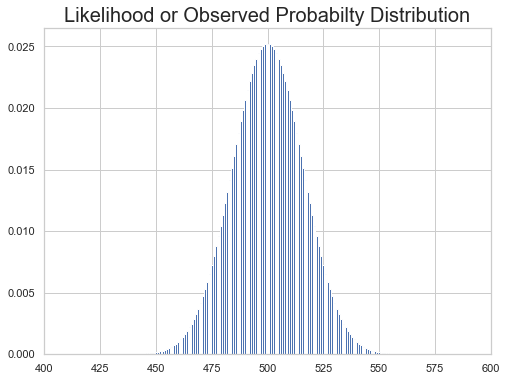

In [44]:
# Flip a fair (or balanced) coin a large number of times

plt.figure(figsize = (8, 6))
r = range(1, 1000)
plt.title('Likelihood or Observed Probabilty Distribution', fontsize = 20)
plt.bar(r, stats.binom.pmf(r, p=0.5, n=1000))
plt.xlim([400, 600])

## Concrete Distinctions

### Frequentist v. Bayesian

* **Frequentist**: Probability is observed as the result of an “infinite” series of trials.  Data are a random sample from a fixed DGP, and the parameters are fixed.

* **Bayesian**: Probability is the observer’s degree of belief.  Data are observed and therefore fixed by the sample generated, and the parameters are described probabilistically.

* **Frequentist**: Point estimates and standard errors.  95% confidence intervals that cover the true parameter value in “19 out of 20 repeated samples.”  Classical hypothesis testing using rejection regions based on confidence intervals.

* **Bayesian**: Summary statistics from posterior distribution, such as averages and percentiles.  95% credible intervals. Probability statements regarding hypotheses: $P(heads) \ge 0.5$.

# Example 1: Is a Coin Balanced?

## Frequentist Approach

1. State a null hypothesis that the coin is balanced. H$_0$: Pr(heads) = 0.5. 


2. Establish a rejection region for the null hypothesis.


3. Obtain data by flipping a coin 10 times.  (Remember the discussion about independent trials, and Markov's insight that dependence could still generate stable limiting distributions.)


4. Calculate the sample proportion as $\hat p$ = (number of heads) / 10.  Calculate the t-stat for this statistic, $\displaystyle{\hat p \big/ \sqrt{\frac{\hat p (1 - \hat p)}{10}}}$.


5. If the outcome were 5 heads, a data scientist would fail to reject the null because the t-stat would be zero.  



* This approach does not allow for a data scientist to express her prior beliefs regarding the nature of coin, in particular whether she believes it is balanced.  Moreover, once she make a decision about whether to reject or fail to reject $H_0$, what could she do with additional data?  



## Bayesian Approach

1. Express your prior beliefs ("priors") in terms of a probability distribution function about the coin itself.  In this example, such priors may be a uniform probability distribution function ("vague" or "uninformed" priors).  Alternatively, your beliefs may be that the coin is not balanced because tails is more likely than heads or heads is more likely than tails because you have prior information.  Alternatively, you may express a high degree of belief that the coin is balanced (again expressed a probability distribution function).


2. Obtain data by flipping a coin 10 times.  (Recall that we can express the DGP of coin flipping as a binomial distribution, which we call the likelihood.)


3. Based on the observed outcomes, generate a posterior probability distribution function about the nature of the coin by combining your priors with the likelihood.  Because we have a probability distribution function, we can calculate many different things, such as an average, a standard deviation, and whether Pr(heads) $\ge$ 0.5.



Let's do this in R.  

(NB: This example works well because of the so-called "conjugate prior".  I don't want to dwell on this.  I want you to see a visualization that is aimed show you how a prior interacts with experimental data to affect a posterior.  We break away from the need of conjugacy through the use of MCMC simulation.)

# R Visualization

# A Criticism and The Response

* The standard criticism of the Bayesian approach to inference is that a data scientist's prior beliefs are subjective.  



* This is true.  But the prior beliefs are openly and explicitly stated in probabilistic terms.  In other words, the priors are an overt and clear statement regarding model assumptions.  Moreover, the use of prior beliefs is a systematic way to incorporate prior "domain knowledge" on a subject (that is, expertise).  Finally, it can be shown that the formulation of the posterior probability distribution function is dominated by the observed data, not by the the data scietist's prior beliefs or expertise.



* Unlike the frequestist approach, the Bayesian approach provides a rigorous way to make probability statements about the real quantities of interest for a data scientist.  It does not view these real quantities as fixed in repeated samples, an assumption that lies at the heart of frequentist approach.  The Bayesian approach also permits the ability to update these probability statements as new infromation is received.  This is a form of learning.  



* Finally, as noted in the New York Times article, the Bayesian approach is proving successful when applied in a variety of different contexts.  (And its use in data science is growing considerably with computational power and open-source statistical computing.)



* Consider the current COVID-19 crisis: sparse data that arrives sporadically.  

# What Do (We) Bayesians Need for Inference?

* The formal estimation of a Bayesian model is the most difficult undertaking in Bayesian analysis.  The simple coin flipping example was instructive, but it relies on conjugacy, which is a limitation.  



* The modern Bayesian approach is to summarize the $entire$ posterior probability distribution, which is necessary to make probabilistic statements about real quantities of interest for data scientists.  (The Bayes calculation in the video example produces a single value.  In truth, modern Bayesian inference relies on a probability distribution.)  



* This undertaking is achieved through Markov Chain Monte Carlo (MCMC) simulation, and I will now show two popular MCMC algorithms using the bivariate normal distribution.

## The Return of the Bivariate Normal

* Recall that we have looked at the bivariate normal distribution.  It was used to generate the first scatterplot for this class.  We are going to use this distribution to implement the Gibbs MCMC algorithm.  



* We will see even if we have a starting value for our MCMC process that is far away from the distribution that we are simulating, we are able to converge rapidly through a process called "burn in".  Once our MCMC sequence has burned in, it will sample the distribution in a manner that is proportional to the distribution being simulated.  

#### Notes
* Recall the 3D image for the bivariate normal.  Keep this image in your mind.  
* The bluer the region, the less likely is it.  The redder the region, the more likely it is.
* Recall the contour slices show what we will are simulating.
* The darker the ring, the more likely it the area within it.

Text(0.5, 0.92, 'Bivariate Normal, $\\rho = 0.5$')

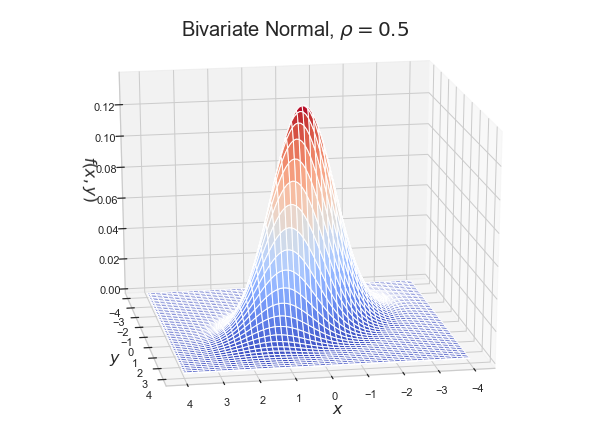

In [45]:
import matplotlib.cm as cm

x, y = np.linspace(-4, 4, 100), np.linspace(-4, 4, 100)
x, y = np.meshgrid(x, y)
z = np.mat(np.zeros(2))
p = np.zeros(np.shape(x))
R = np.matrix([[1, 0.5],[0.5, 1]])
Rinv = linalg.inv(R)

for i in range(len(x)):
    for j in range(len(y)):
        z[0, 0] = x[i, j]
        z[0, 1] = y[i, j]
        p[i, j] = (1.0 / (2 * np.pi) * np.sqrt(linalg.det(R))) * np.exp(-(z * Rinv *z.T) / 2)

fig = plt.figure(figsize = (8, 6))
ax = Axes3D(fig)
#ax.plot_wireframe(x, y, p, rstride=3, cstride=3, color='#AD5300')
ax.plot_surface(x, y, p, rstride=2, cstride=2, cmap=cm.coolwarm, shade='interp')
#ax.plot_wireframe(x, y, p, rstride=3, cstride=3, color='black')
ax.view_init(20, 80) # rotation through 20, 40, 60, 80
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$y$', fontsize = 16)
ax.set_zlabel(r'$f(x, y)$', fontsize = 16)
ax.set_title(r'Bivariate Normal, $\rho = 0.5$', fontsize = 20)

Text(0.5, 1.0, 'Contour Slices of Bivariate Normal, $\\rho = 0.5$')

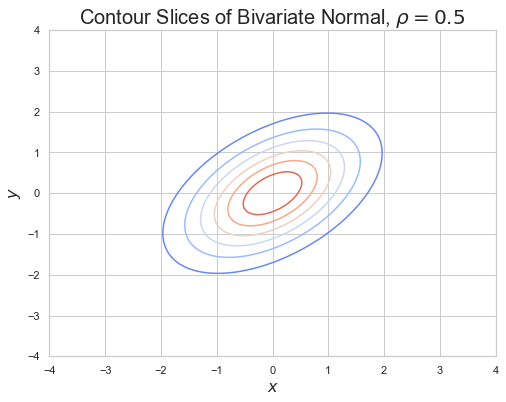

In [46]:
fig = plt.figure(figsize = (8, 6))
ax = fig.gca()
ax.contour(x, y, p, cmap=cm.coolwarm)  
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel(r'$x$', fontsize = 16)
ax.set_ylabel(r'$y$', fontsize = 16)
ax.set_title(r'Contour Slices of Bivariate Normal, $\rho = 0.5$', fontsize = 20)

## MCMC Simulation Using The Gibbs Algorithm 

* The Gibbs algorithm is a Markov chain Monte Carlo (MCMC) method to simulate a sequence of observations, as an approximation, when direct sampling is difficult. 
* The sequence geneated by this method can be used to approximate through historgrams:
    1. a joint distribution
    2. a marginal distribution of one of the variables
    3. an integral to be used generate averages

* It is a simple method that makes use of random numbers that generates a Markov chain. 
* We need time for the Markov chain to converge, referred to as the "Burn In".  
* This is Gibbs algorithm to simulate the contour slices of a bivariate normal with $\rho = 0.5$.
* Start the MCMC chain at an arbitrary starting value (-10, -10).
* Our results are not dependent on this artibrary starting value.
* In the code below, mc is the number of mcmc replications.
* start is the random starting point, (start, start).

In [47]:
mc = 10000 
start = -10

x = np.zeros(mc)
y = np.zeros(mc)  
x[0], y[0] = start, start

for i in range(2, mc): 
    x[i] = np.random.normal(loc = 0.5 * y[i-1], scale = np.sqrt(1 - 0.5 * 0.5), size=1) 
    y[i] = np.random.normal(loc = 0.5 * x[i], scale = np.sqrt(1- 0.5 * 0.5), size=1)

#### Notes
* We start the MCMC chain at an arbitrary point and follow its progression by connecting all the simulated points with a line.
* We want to see the simulated point "build up" throughout the support of the bivariate normal.

Text(0.5, 1.0, 'First 25 Iterations of Gibbs Algorithm')

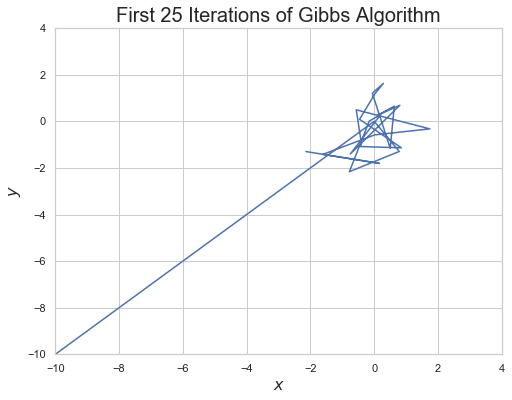

In [48]:
plt.figure(figsize = (8, 6))
plt.plot(x[0:24], y[0:24], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 25 Iterations of Gibbs Algorithm', fontsize = 20)

Text(0.5, 1.0, 'First 50 Iterations of Gibbs Algorithm')

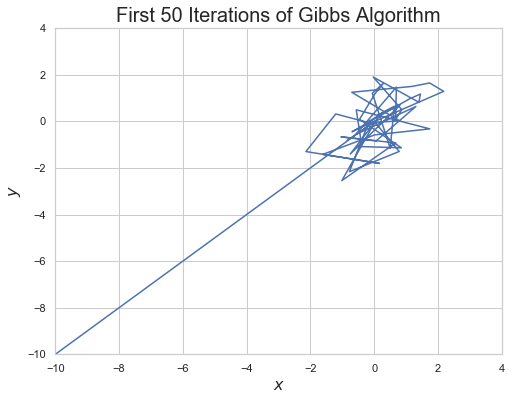

In [49]:
plt.figure(figsize = (8, 6))
plt.plot(x[0:49], y[0:49], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 50 Iterations of Gibbs Algorithm', fontsize = 20)

Text(0.5, 1.0, 'First 500 Iterations of Gibbs Algorithm')

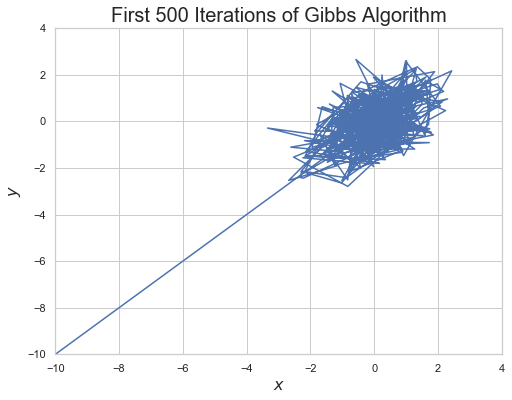

In [50]:
plt.figure(figsize = (8, 6))
plt.plot(x[0:499], y[0:499], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 500 Iterations of Gibbs Algorithm', fontsize = 20)

Text(0.5, 1.0, 'First 1,000 Iterations of Gibbs Algorithm')

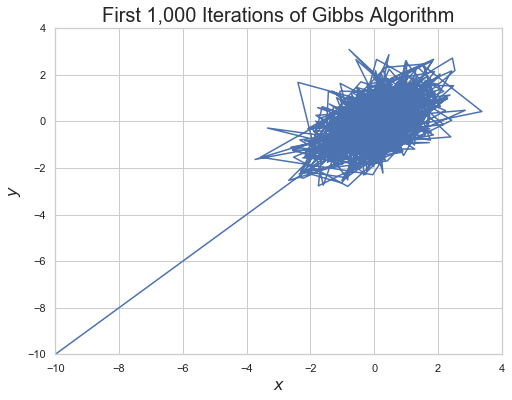

In [51]:
plt.figure(figsize = (8, 6))
plt.plot(x[0:999], y[0:999], 'b')
plt.xlim(-10,4)
plt.ylim(-10,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'First 1,000 Iterations of Gibbs Algorithm', fontsize = 20)

#### Notes

* Treat the first 500 MCMC replications as the burn in and discard them.
* Generate a scatterplot of the remaining replications.
* Keeping in mind the bivariate normal, notice what is important in these MCMC replications.
    1. Their coverage is dense where the bivariate normal is most probable.
    2. It is sparse where the bivariate normal is the least probable.
* This is the the key to simulating a distribution function using MCMC.

Text(0.5, 1.0, 'Scatterplot of Gibbs Algorithm After Burn-In: Joint Distribution')

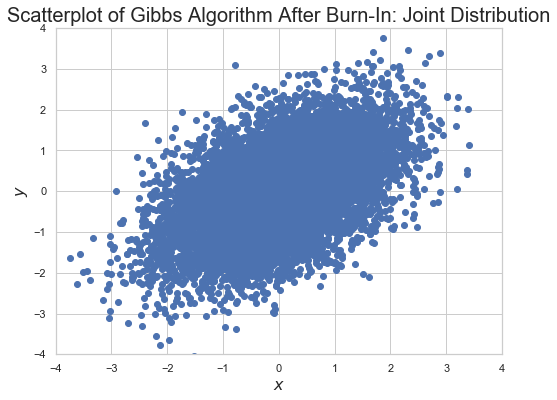

In [52]:
plt.figure(figsize = (8, 6))
plt.scatter(x[499:9999], y[499:9999], c='b')
plt.xlim(-4, 4)
plt.ylim(-4 ,4)
plt.xlabel(r'$x$', fontsize = 16)
plt.ylabel(r'$y$', fontsize = 16)
plt.title(r'Scatterplot of Gibbs Algorithm After Burn-In: Joint Distribution', fontsize = 20)

#### Notes

* Having simulated the bivariate normal with the Gibbs algorithm, we can examine to key aspects discussed above. # Calculate the average posterior together with 95% credible interval.
* We have basically recreated the univariate normal with mean zero and variance one.

The average is -0.010799
The 2.5 and 97.5 percentiles are -1.986428 and 1.957425


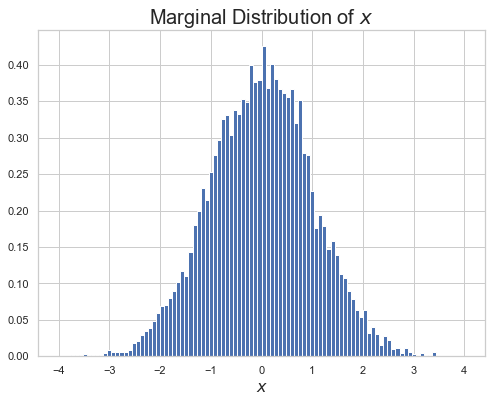

In [53]:
plt.figure(figsize = (8, 6))
plt.hist(x[499:9999], bins=100, range=(-4, 4), normed=True, color='b')
plt.xlabel(r'$x$', fontsize = 16)
plt.title(r'Marginal Distribution of $x$', fontsize = 20)

mean = x[499:9999].mean()
p2 = np.percentile(x[499:9999], 2.5)
p97 = np.percentile(x[499:9999], 97.5)
print("The average is %f" % mean)
print("The 2.5 and 97.5 percentiles are %f and %f" % (p2, p97))

The average is -0.007361
The 2.5 and 97.5 percentiles are -1.980152 and 1.960079


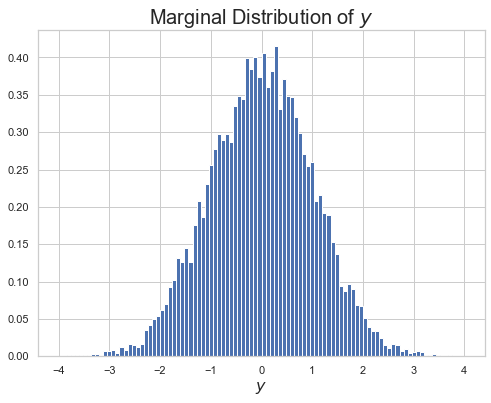

In [54]:
plt.figure(figsize = (8, 6))
plt.hist(y[499:9999], bins=100, range=(-4, 4), normed=True, color='b')
plt.xlabel(r'$y$', fontsize = 16)
plt.title(r'Marginal Distribution of $y$', fontsize = 20)

mean = y[499:9999].mean()
p2, p97 = np.percentile(y[499:9999], 2.5), np.percentile(y[499:9999], 97.5)
print("The average is %f" % mean)
print("The 2.5 and 97.5 percentiles are %f and %f" % (p2, p97))

## MCMC Simulation Using the Metropolis-Hastings Algorithm

#### Notes
* Metropolis Hasting is another MCMC algorithm that is useful.  Focus on what is occuring rather than the underlying code.
* One parameter of interest for the bivariate normal distribution is $\rho$, the correlation coefficient.  
* We are going to use the Metropolis-Hasting MCMC algorithm to simulate the posterior distribution of $\rho$ and to conduct Bayesian hypothesis testing.

* The posterior density of $\rho$ is:

$f(\rho | x, y) = (1 - \rho^2)^{-(N + 3)/2} \exp \left\{-\frac{1}{2(1 - \rho^2)} [\sum x_i^2 + \sum y_i^2 - 2 \rho \sum x_i y_i] \right\}$

$\log f(\rho | x, y) = -\frac {N + 3}{2} \log(1 - \rho^2) - \left\{\frac{1}{2(1 - \rho^2)} [\sum x_i^2 + \sum y_i^2 - 2 \rho \sum x_i y_i] \right\}$

* Using Metropolis Hasting algorithm, sample from (log) posterior of $\rho$ using the bivariate normal with mean zero, variance 1, and $\rho = 0.5$.
* ss is the sample size of the observed data
* draws is the number of MCMC draws
* Plot the first 50 MCMC Replications starting at $\rho = 0$.
* Again we want to see this MCMC algorithm burn in, converging to a value around $\rho = 0.5$ and stay in that region.

In [55]:
ss = 1000 
mean = [0,0]
random.seed(11192018)
R = np.matrix([[1, 0.5],[0.5, 1]])

draws = 10000 
corr = np.zeros(draws) # Initialize vector containing draws
acctot = 0 # A counter for accepted MCMC draws
adj = (ss + 3.0) / 2.0 # Sample size adjustment in the log posterior of rho

x, y = np.random.multivariate_normal(mean, R, ss).T # Draw the observed data

# Commence MH algorithm at 0
for i in range(1, draws):
    acc = 1 # Assume acceptible draw
    corr[i] = corr[i - 1] + np.random.uniform(-.07, .07, 1) # Add symmetric random variable 
    
    if abs(corr[i]) > 1: 
        corr[i] = corr[i-1] # Don't change 
    
    # Evaluation of current and prior draw
    a = -adj * np.log(1 - corr[i] ** 2) - 0.5 * (np.sum(x ** 2) - 2.0 * corr[i] * np.sum(x * y) 
                                                 + np.sum(y ** 2)) / (1 - corr[i] ** 2)
    b = -adj * np.log(1 - corr[i-1] ** 2) - 0.5 * (np.sum(x ** 2) - 2.0 * corr[i-1] * np.sum(x * y) 
                                                   + np.sum(y ** 2)) / (1 - corr[i-1] ** 2)
                
    if (a - b) < np.log(np.random.uniform(0, 1, 1)): # Metropolis Hastings criterion for rejection
        acc = 0 # Reject
        corr[i] = corr[i-1] # Don't change
        
    acctot += acc

Text(0.5, 0, 'Draw')

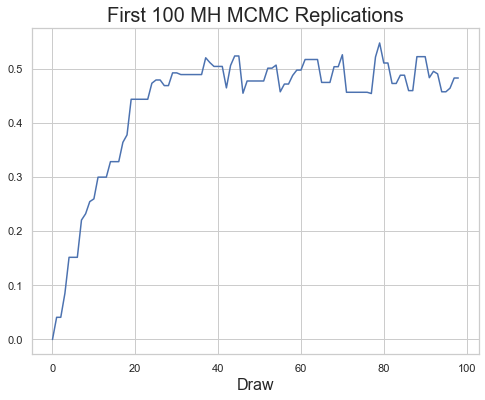

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(corr[0:99], c='b')
plt.title('First 100 MH MCMC Replications', fontsize = 20)
plt.xlabel('Draw', fontsize = 16)

Text(0.5, 0, 'Replication')

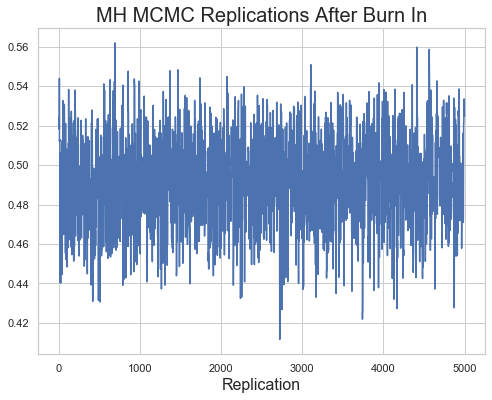

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(corr[4999:9999], c='b')
plt.title('MH MCMC Replications After Burn In', fontsize = 20)
plt.xlabel('Replication', fontsize = 16)

(0.4, 0.6)

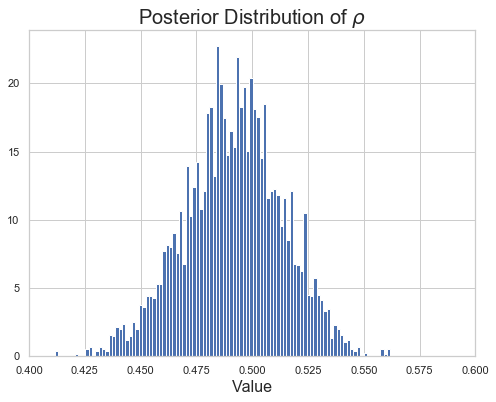

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(corr[4999:9999], bins=100, normed=True, color='b')
plt.title(r'Posterior Distribution of $\rho$', fontsize = 20)
plt.xlabel('Value', fontsize = 16)
plt.xlim(0.4, 0.6)

#### Notes
* Consider the frequentist interpretation, where $\rho$ is a fixed value.
* The Bayesian intepretation is that $\rho$ has a posterior probability distribution with particular characteristics.
* Bayesian inference using simulated posterior from MCMC.
* Average of the posterior after burn-in.
* Standard deviation of the posteriod after burn-in.
* 95% Credible interval after burn-in.

In [59]:
print("The observed correlation in our simulated data are %f" % np.corrcoef(x, y)[1, 0])

The observed correlation in our simulated data are 0.484567


In [60]:
print("The average of MCMC replications after burn in is %f" % corr[4999:9999].mean())
print("The standard deviation of MCMC replications after burn in is %f" % corr[4999:9999].std())
print("The 95% credible interval of MCMC replciations after burn in is", np.percentile(corr[4999:9999], (2.5, 97.5)))
print("The probability rho exceeds 0.5 is %f" % np.mean(corr[4999:9999]>0.5))

The average of MCMC replications after burn in is 0.491472
The standard deviation of MCMC replications after burn in is 0.022005
The 95% credible interval of MCMC replciations after burn in is [0.44658188 0.53276006]
The probability rho exceeds 0.5 is 0.352400


# Example 2: Simulating the posterior probabilty distributions of $\alpha$ and $\beta$ from the CAPM.

In [61]:
# Grab Apple and NASDAQ data.  

start, end = "2006-01-01", "2017-12-31"

aapl_all = yf.download('aapl', start=start, end=end)
nasdaq_all = yf.download('^ixic', start=start, end=end)
aapl = aapl_all['Adj Close']
nasdaq = nasdaq_all['Adj Close']
aapl_returns = (np.log(aapl / aapl.shift(1))).dropna()
nasdaq_returns = (np.log(nasdaq / nasdaq.shift(1))).dropna()

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


Text(0.5, 1.0, 'AAPL ($/Share)')

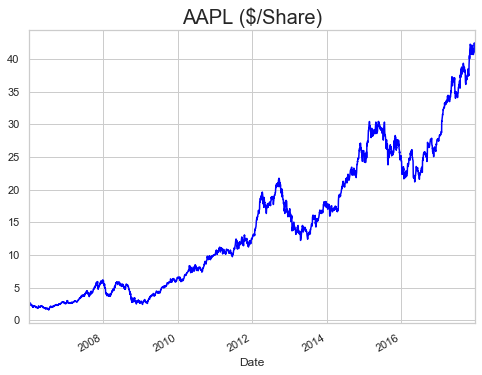

In [62]:
plt.figure(figsize=(8, 6))
aapl.plot(color='blue')
plt.title('AAPL ($/Share)', fontsize=20)

In [63]:
aapl_r = pd.DataFrame(aapl_returns)
nasdaq_r = pd.DataFrame(nasdaq_returns)
data = pd.merge(nasdaq_r, aapl_r, left_index=True, right_index=True)
data.rename(columns={'Adj Close_x':'nasdaq', 'Adj Close_y':'aapl'}, inplace=True)
mod = smf.ols(formula='aapl ~ nasdaq', data = data).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     2309.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:51:28   Log-Likelihood:                 8319.9
No. Observations:                3019   AIC:                        -1.664e+04
Df Residuals:                    3017   BIC:                        -1.662e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0006      0.000      2.038      0.0

#### Notes
* For more sophisticated MCMC simulation, we use PyMC3, a popular Python library for Bayesian inference.
* We will simulate the posterior probability distributions of alpha and beta from CAPM.  
* We will show how hypothesis testing using a Bayesian approach is straightforward and could be the basis of decision making.
* See https://pymc-devs.github.io/pymc3/getting_started/.

In [64]:
with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = 8,300.9, ||grad|| = 3,115.5: 100%|██████████| 27/27 [00:00<00:00, 537.90it/s]         
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 282.52draws/s]


<Figure size 720x720 with 0 Axes>

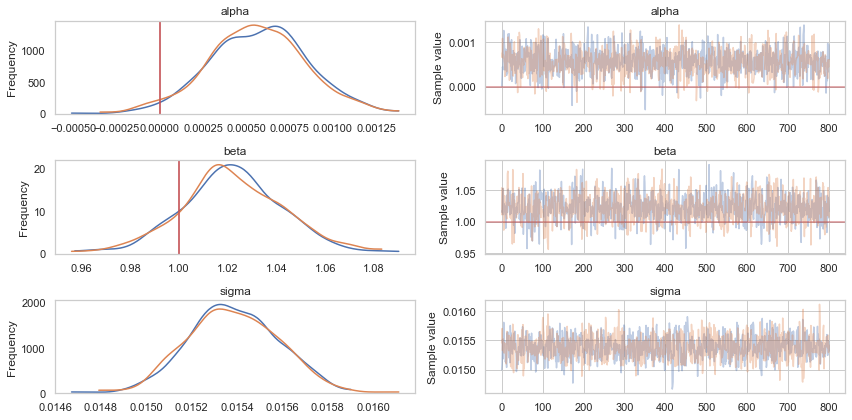

<Figure size 720x720 with 0 Axes>

In [65]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (10, 10))

#### Notes
* This is the strength of the Bayesian approach.  
* Using transparent prior beliefs, combined with real-world data, we have simulated the posterior distribution functions of two quantities of interest to a data scientist.  
* (You can ignore sigma stuff.)
* Having simulated the entire posterior probability distributions, we can calculate useful metrics.
* Start with averages and 95% credible intervals.
* Note their simularity to the least squares results.

In [66]:
alphamean = np.mean(trace['alpha'][199:1000])
alphap2, alphap97 = np.percentile(trace['alpha'][199:1000], (2.5, 97.5))
betamean = np.mean(trace['beta'][199:1000])
betap2, betap97 = np.percentile(trace['beta'][199:1000], (2.5, 97.5))

print("Average alpha and its 95 percent credible interval are %f %f %f" % (alphamean, alphap2, alphap97))
print("Average beta and its 95 percent credible interval are %f %f %f" % (betamean, betap2, betap97))
print()
print(mod.summary())

Average alpha and its 95 percent credible interval are 0.000575 0.000017 0.001128
Average beta and its 95 percent credible interval are 1.022076 0.982096 1.062971

                            OLS Regression Results                            
Dep. Variable:                   aapl   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     2309.
Date:                Sun, 27 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:52:01   Log-Likelihood:                 8319.9
No. Observations:                3019   AIC:                        -1.664e+04
Df Residuals:                    3017   BIC:                        -1.662e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t   

In [67]:
print ("The probability that alpha is greater than zero is %f" % np.mean(trace['alpha'][199:1000] > 0.0))
print ("The probability that beta is less than one is %f" % np.mean(trace['beta'][199:1000] < 1.0))
print("The joint probability is %f" % np.all([[trace['alpha'][199:1000] > 0.0], [trace['beta'][199:1000] < 1.0]], axis = 0).mean())

The probability that alpha is greater than zero is 0.977528
The probability that beta is less than one is 0.137328
The joint probability is 0.136080


### How Do the Priors Affect the Posteriors?
* Use a different set of prior probabilities.
* Results do not change because in truth the data themselves drive the results.

In [68]:
with pm.Model() as model:
    # alpha, beta, and sigma are the hyperparameters over which we have our priors, in this case they are flat priors.    
    alpha = pm.Uniform('alpha', lower=-1, upper=1)
    beta = pm.Uniform('beta', lower=0, upper=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta * nasdaq_returns
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=aapl_returns)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = 8,316.2, ||grad|| = 11.383: 100%|██████████| 25/25 [00:00<00:00, 1070.76it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:10<00:00, 283.39draws/s]


<Figure size 720x720 with 0 Axes>

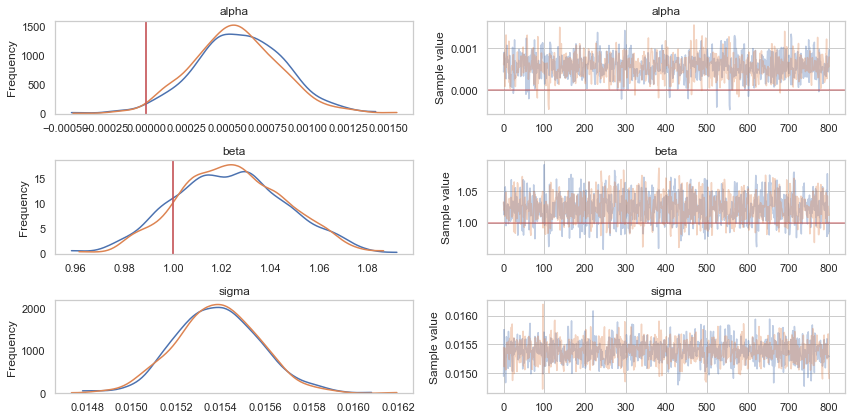

<Figure size 720x720 with 0 Axes>

In [69]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000], lines={'alpha': 0, 'beta': 1})
plt.figure(figsize = (10, 10))

In [70]:
print ("The probability that alpha is greater than zero is %f" % np.mean(trace['alpha'][199:1000] > 0.0))
print ("The probability that beta is less than one is %f" % np.mean(trace['beta'][199:1000] < 1.0))
print ("The joint probability is %f" % np.all([[trace['alpha'][199:1000] > 0.0], [trace['beta'][199:1000] < 1.0]], axis = 0).mean())

The probability that alpha is greater than zero is 0.980025
The probability that beta is less than one is 0.168539
The joint probability is 0.163546


### Another Example

In [71]:
griliches = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Griliches.csv")
griliches = griliches.drop(griliches.columns[0], 1)
griliches = griliches[['lw', 'school', 'iq', 'age', 'expr', 'tenure', 'med']]

In [72]:
mod = smf.ols(formula = 'lw ~ school + iq + age + expr + tenure + med', data = griliches).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                     lw   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     81.33
Date:                Sun, 27 Dec 2020   Prob (F-statistic):           2.51e-78
Time:                        18:52:41   Log-Likelihood:                -243.72
No. Observations:                 758   AIC:                             501.4
Df Residuals:                     751   BIC:                             533.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3016      0.122     26.962      0.0

In [73]:
# Create numpy arrays for PyMC3

lw = griliches['lw'].as_matrix()
school = griliches['school'].as_matrix()
iq = griliches['iq'].as_matrix()
age = griliches['age'].as_matrix()
expr = griliches['expr'].as_matrix()
tenure = griliches['tenure'].as_matrix()
med = griliches['med'].as_matrix()

In [74]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta1 = pm.Normal('beta1', mu=0, sd=20)
    beta2 = pm.Normal('beta2', mu=0, sd=20)
    beta3 = pm.Normal('beta3', mu=0, sd=20)
    beta4 = pm.Normal('beta4', mu=0, sd=20)
    beta5 = pm.Normal('beta5', mu=0, sd=20)
    beta6 = pm.Normal('beta6', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta1 * school + beta2 * iq + beta3 * age + beta4 * expr + beta5 * tenure + beta6 * med 
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=lw)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = -273.44, ||grad|| = 2.1271: 100%|██████████| 72/72 [00:00<00:00, 506.69it/s]      
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta6, beta5, beta4, beta3, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:55<00:00, 54.13draws/s]


<Figure size 720x720 with 0 Axes>

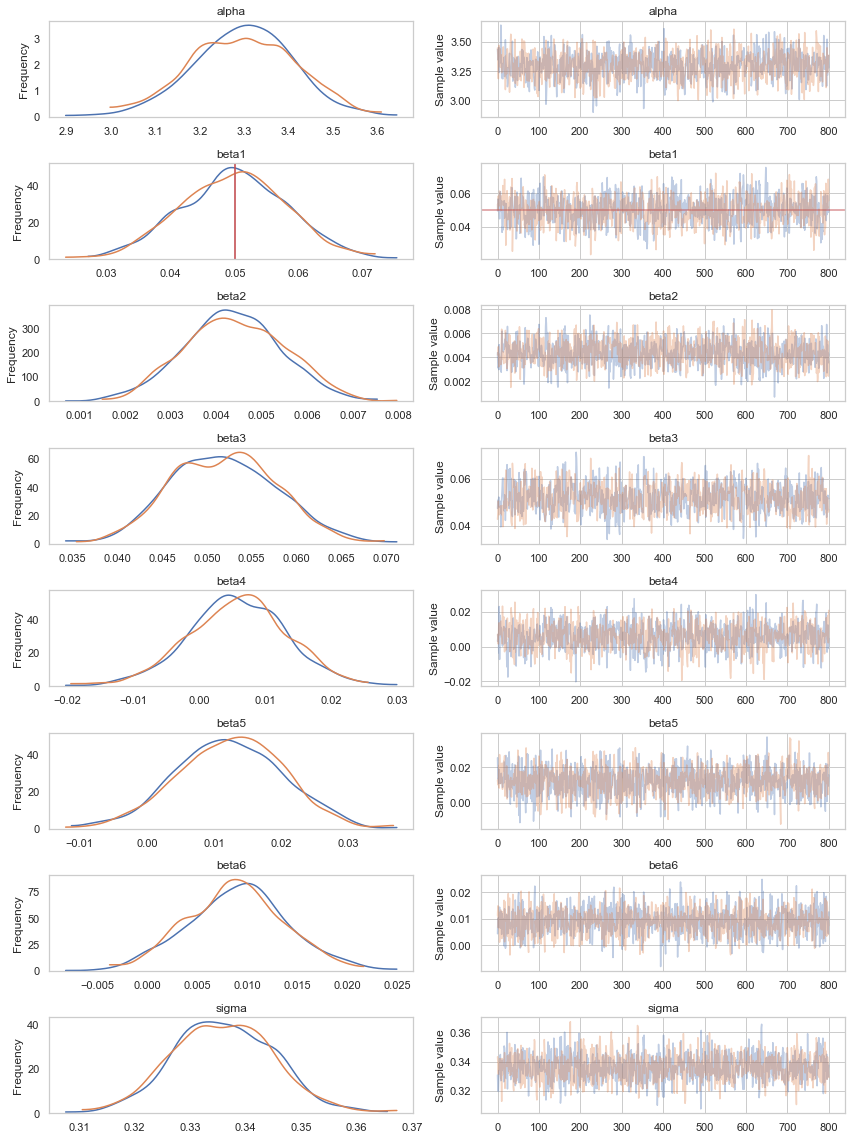

<Figure size 720x720 with 0 Axes>

In [75]:
# Show results after burn in of 200 MCMC replications.

fig = pm.traceplot(trace[199:1000], lines={'beta1': 0.05})
plt.figure(figsize = (10, 10))

In [76]:
print("The probability that returns to schooling exceed 0.05 is %f" % np.mean(trace['beta1'][199:1000] > 0.05))

The probability that returns to schooling exceed 0.05 is 0.500624


In [77]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta1 = pm.Normal('beta1', mu=0.10, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=20)
    beta3 = pm.Normal('beta3', mu=0, sd=20)
    beta4 = pm.Normal('beta4', mu=0, sd=20)
    beta5 = pm.Normal('beta5', mu=0, sd=20)
    beta6 = pm.Normal('beta6', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta1 * school + beta2 * iq + beta3 * age + beta4 * expr + beta5 * tenure + beta6 * med 
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=lw)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = -270.45, ||grad|| = 80.773: 100%|██████████| 127/127 [00:00<00:00, 346.52it/s]       
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta6, beta5, beta4, beta3, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:51<00:00, 58.13draws/s]


In [78]:
print("The probability that returns to schooling exceed 0.05 is %f" % np.mean(trace['beta1'][199:1000] > 0.05))

The probability that returns to schooling exceed 0.05 is 0.498127


In [79]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta1 = pm.Normal('beta1', mu=0.20, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=20)
    beta3 = pm.Normal('beta3', mu=0, sd=20)
    beta4 = pm.Normal('beta4', mu=0, sd=20)
    beta5 = pm.Normal('beta5', mu=0, sd=20)
    beta6 = pm.Normal('beta6', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    # y_est is the specification of the Bayesian model to be estimated.  It is simply our CAPM.
    y_est = alpha + beta1 * school + beta2 * iq + beta3 * age + beta4 * expr + beta5 * tenure + beta6 * med 
    
    # likelihood is the likelihood function, here it is normal to be used with conjugate priors.    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=lw)
    
    # We use the Maximum a Posteriori (MAP) values as starting values for the MCMC sampling.
    start = pm.find_MAP()
    trace = pm.sample(1000, start=start, nuts_kwargs=dict(target_accept=.9), progressbar=True)

logp = -270.46, ||grad|| = 74.925: 100%|██████████| 113/113 [00:00<00:00, 794.14it/s]        
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta6, beta5, beta4, beta3, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:44<00:00, 67.70draws/s] 


In [80]:
print("The probability that returns to schooling exceed 0.06 is %f" % np.mean(trace['beta1'][199:1000] > 0.06))

The probability that returns to schooling exceed 0.06 is 0.098627


## What Is Artificial Intelligence?
* We have done applied statistical learning during this course.
* This is **NOT** AI.
* Key components of AI:
    * Must be include causal models (using Judea Pearl's framework).
    * Must be probabilistic (that is Bayesian).
    * Unsupervised (so probably not Deep Learning).
        * *The Master Algorithm*, Pedro Domingos